In [1]:
# EOS-BPM Longitudinal resolution study
import copy
from cycler import cycler;
import matplotlib.pyplot as plt;
import numpy as np;
import scipy;
from scipy.constants import c;
from scipy.signal import find_peaks;
import sys;
import time;
sys.path.insert(0, r'../../python/')
import beam_phase_retard as pr;
import two_beam as tb;
# Colors for plotting.
plot_colors = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', \
               '#DDCC77','#CC6677', '#882255',  '#AA4499'];

cy = cycler('color', plot_colors);


# Bunch parameters
Q_drive    = 1.5e-9;
sigz_drive = 5.2e-6;
sigt_drive = sigz_drive/c;
Q_wit      = 0.5e-9;
sigz_wit   = 5.2e-6;
sigt_wit   = sigz_wit/c;
del_z      = 175e-6;
del_t      = del_z/c;
x_drive    = 5.0e-3;
y_drive    = 0.0;
x_wit      = 5.0e-3;
y_wit      = 0.0;
r_drive    = np.sqrt(x_drive**2 + y_drive**2);
r_wit      = np.sqrt(x_wit**2 + y_wit**2);

drive      = {'Q':Q_drive, 'sig_t':30e-15, 'x' : x_drive, 'y' : y_drive};
wit        = {'Q':Q_wit, 'sig_t':sigt_wit, 'x' : x_wit, 'y' : y_wit};

# Crystal parameters (type and thickness)
ctype = 'ZnTe';
d   = 100e-6;
# Probe parameters
y0      = 800e-9;
a_laser = 0 * np.pi / 180;
z_match = 0;
tau     = np.linspace(-200, 1800, 5000) * 1e-15;
probe = {'y0'     :y0, 
         'a_laser': a_laser, 
         'z_match': z_match, 
         'chirp'  : True,
         'width'  : 27e-9};

# time array for THz field
N         = 8000;
dt        = drive['sig_t']/10;
t         = np.linspace(- N * dt/2, N * dt/2, N);

# Compuatational parameters
nslice = int(d * 1e6);
base_params  = {'ctype'    : ctype, 
                't'       : t, 
                'tau'     : tau,
                'nslice'  : nslice,
                'beam1'   : drive,
                'beam2'   : wit,
                't_off'   : del_t,
                'plot'    : False,
                'verbose' : False, 
                'pockel'  : True, 
                'ref'     : True,
                'save'    : False,
                'probe'   : probe}; 

# Function for quick plotting 
def makefig():
    fig = plt.figure(figsize = (6,6), dpi = 200);
    ax  = fig.gca();
    return fig, ax;

ModuleNotFoundError: No module named 'beam_phase_retard'

THz average phase velocity = infc
THz average group velocity = infc
Effective probe velocity = 0.30872683579312493 c
PROBE: 1.1466714437082015


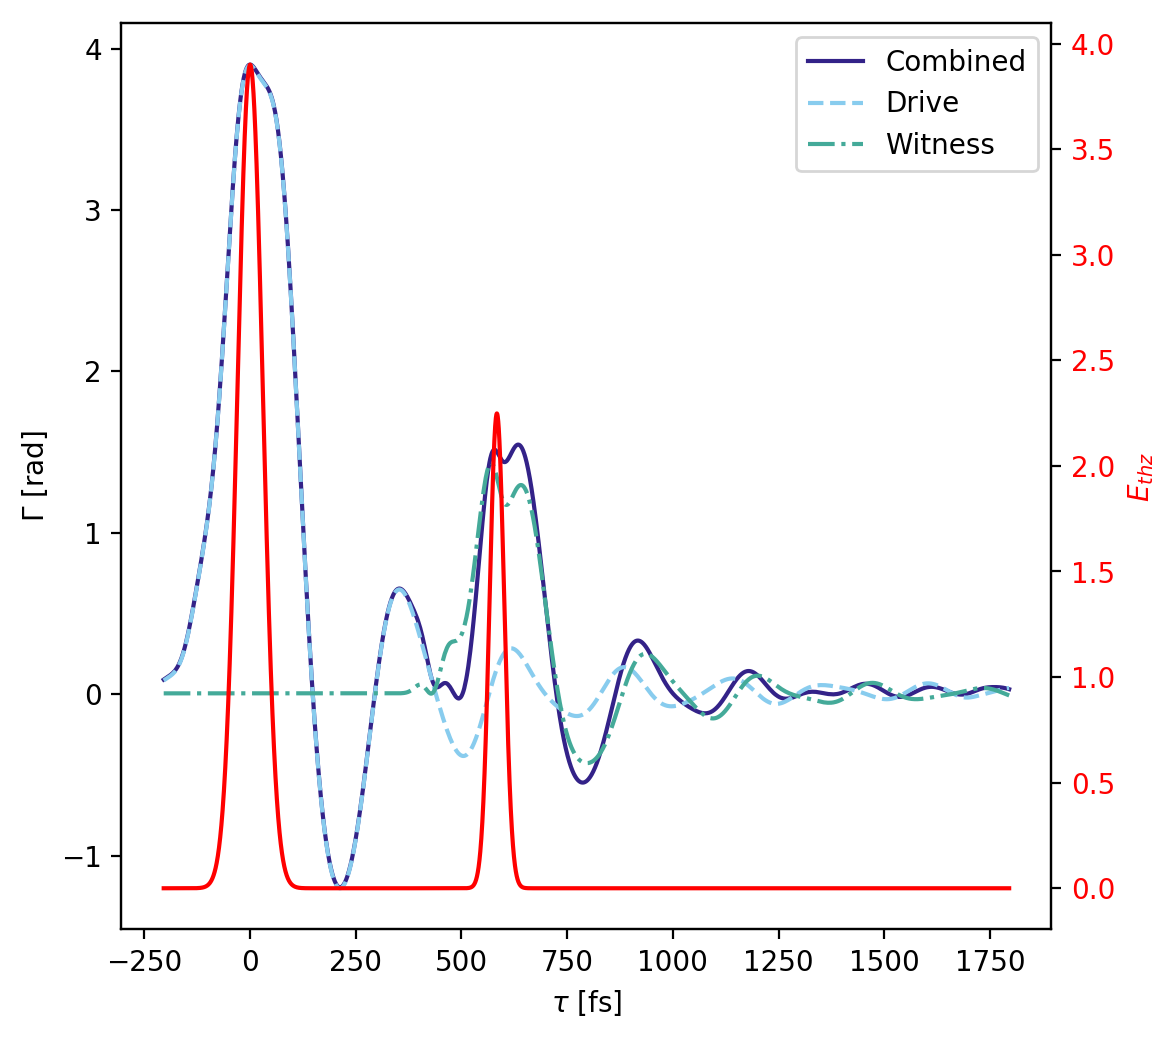

In [15]:
params = copy.deepcopy(base_params);
params['plot'] = True;
params['verbose'] = True;
params['d'] = 100e-6;
params['det'] = '';
pr.phase_retard(params);

In [4]:
del_t


5.83737166596766e-13

In [1]:
# Get peaks of signal;
def get_peaks(signal):
    '''
    Function to find the peaks due to the drive and witness signal
    Parameters:
    -----------
    signal : array_like
             The combined signal of the two beams
    Returns:
    --------
    peaks : array_like
            Array containing the indices of the two peaks
    '''
    max_sig = max(signal);
    # Start cutoff at 5 percent the max signal
    cutoff = 0.05
    peaks = find_peaks(signal, height = cutoff * max_sig)[0];
    npeaks = len(peaks);
    while len(peaks) > 2:
        cutoff = cutoff + 0.025
        # sometimes the 2nd peak repeats
        peaks = find_peaks(signal, height = cutoff * max_sig)[0];
        if len(peaks) == 1: #npeaks and len(peaks) == 3:
            cutoff = cutoff - 0.025
            peaks = find_peaks(signal, height = cutoff * max_sig)[0];
            peaks = [peaks[0], peaks[1]];
            break;
        npeaks == len(peaks);
    return peaks;

In [3]:
# Table of peak to peak measurements vs. offsets:
def measured_offset():
    offsets = np.arange(125, 176, 5) * 1e-6;
    gamma_z = np.zeros(len(offsets));
    signal_z = np.zeros(len(offsets));
    # params1 1mm offset, params2 3mm offset;
    params1 = dict(base_params);
    params1['det'] = 'cross';
    params1['d'] = 100e-6;
    params1['plot'] = False;
    params2 = copy.deepcopy(params1)
    params2['d'] = 100e-6;
    params2['det'] = 'cross';
    params2['plot'] = False;
    params2['beam1']['x'] = 3.0e-3;
    params2['beam2']['x'] = 3.0e-3;
    for i in range(len(offsets)):
        print(params1['beam1']['x'], params1['beam2']['x'])
        print(params2['beam1']['x'], params2['beam2']['x'])
        del_t = offsets[i] / c;
        params1['t_off'] = del_t;
        params2['t_off'] = del_t;
        dummy, dummy, gamma1, tau1 = pr.phase_retard(params1);
        dummy, dummy, gamma2, tau2 = pr.phase_retard(params2);
        gamma_peaks = get_peaks(gamma1);
        signal_peaks = get_peaks(np.sin(gamma2 / 2)**2);
        gamma_z[i] = (tau1[gamma_peaks[-1]] - tau1[gamma_peaks[0]]) * 1e-15;
        signal_z[i] = (tau2[signal_peaks[-1]] - tau2[signal_peaks[0]]) * 1e-15;
        # Convert to distance
        gamma_z[i] = gamma_z[i] * c;
        signal_z[i] = signal_z[i] * c;
        print(offsets[i] * 1e6, gamma_z[i] * 1e6, signal_z[i] * 1e6);
#measured_offset();

[0.53552825 0.53572828 0.5359283  ... 1.53505155 1.53525157 1.5354516 ]
[0.54750814 0.54770813 0.54790812 ... 1.54687817 1.54707817 1.54727818]
[0.55948802 0.55968798 0.55988794 ... 1.5587048  1.55890476 1.55910476]
[0.5714679  0.57166783 0.57186776 ... 1.57053142 1.57073136 1.57093134]
[0.58344778 0.58364768 0.58384758 ... 1.58235805 1.58255795 1.58275792]
[0.59542766 0.59562753 0.59582739 ... 1.59418467 1.59438455 1.5945845 ]
[0.60740754 0.60760738 0.60780721 ... 1.6060113  1.60621115 1.60641108]
[0.61938743 0.61958723 0.61978703 ... 1.61783792 1.61803774 1.61823765]
[0.63136731 0.63156708 0.63176685 ... 1.62966455 1.62986434 1.63006423]
[0.64334719 0.64354693 0.64374667 ... 1.64149117 1.64169093 1.64189081]
[0.65532707 0.65552678 0.65572649 ... 1.6533178  1.65351753 1.65371739]
[0.66730695 0.66750663 0.6677063  ... 1.66514442 1.66534412 1.66554397]
[0.67928683 0.67948648 0.67968612 ... 1.67697105 1.67717072 1.67737055]
[0.69126672 0.69146633 0.69166594 ... 1.68879767 1.68899731 1.68

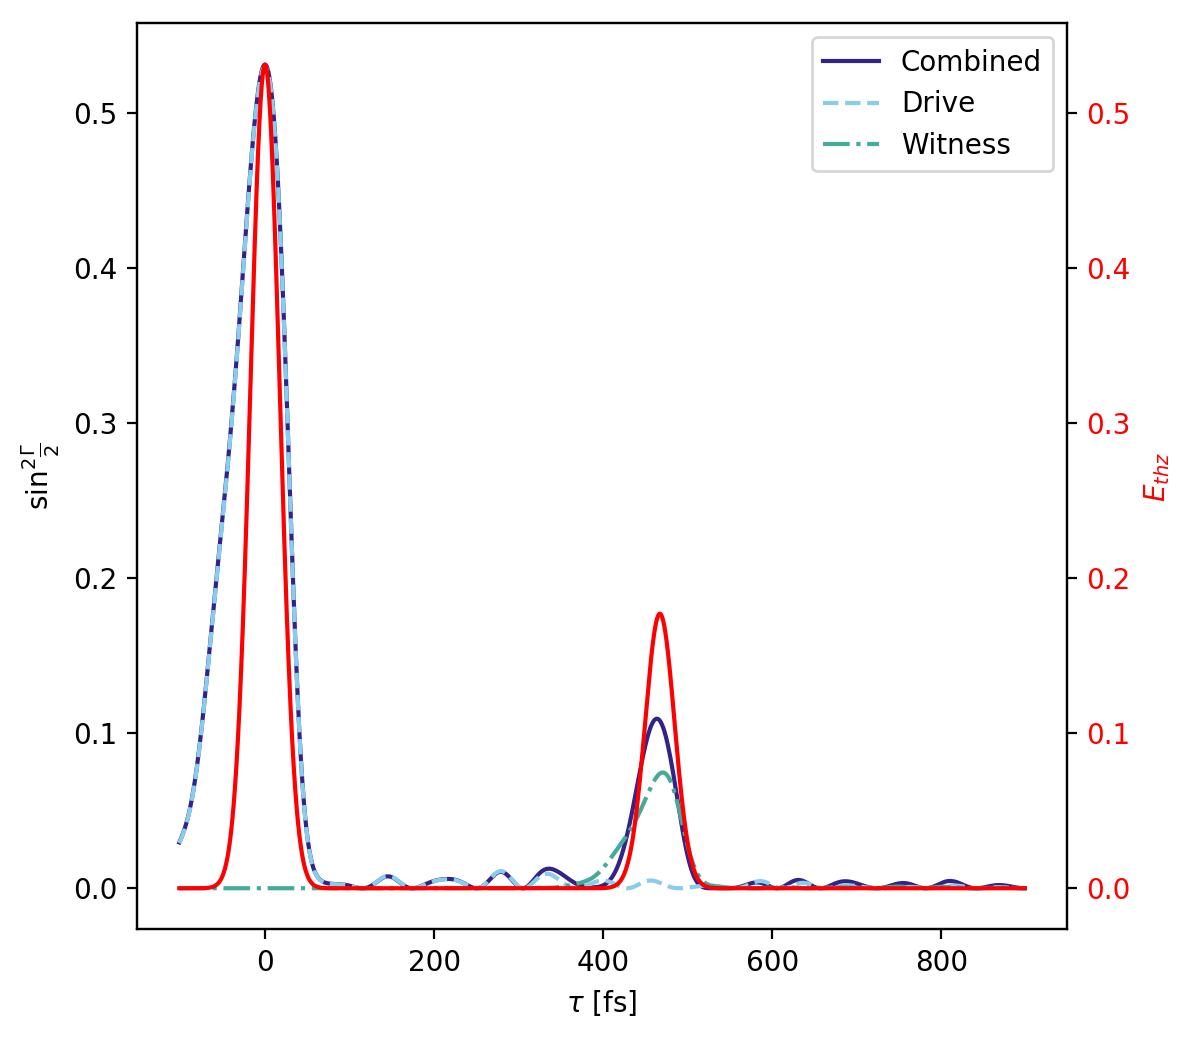

In [4]:
params = dict(base_params);
params['det'] = 'cross';
params['plot'] = True;
params['t_off'] = 140e-6 / c;
params['d'] = 100e-6;
params['beam1']['x'] = 3e-3;
params['beam2']['x'] = 3e-3;
dummy, dummy, sig, tau = pr.phase_retard(params);
#fig, ax = makefig();

In [7]:
tau[-1]

898.5797159431887

In [10]:
print(tt[0], tt[-1])

-20.815731096627506 6.938577032209167


In [10]:
get_peaks(np.sin(sig / 2)**2)

array([507])

In [11]:
x = [5, 3, 3];
np.argmin(x)

1

In [1]:
# Find optimal crystal thickness for resolving witness beam
def depth_study(r0):
    params = base_params;
    #params['ctype'] = 'ZnTe';
    params['ctype'] = 'GaP'
    params['beam1']['x'] = r0;
    params['beam2']['x'] = r0;
    d_cry   = np.arange(50e-6, 251e-6, 5e-6)
    sig_bal = np.zeros(len(d_cry));
    sig_x   = np.zeros(len(d_cry)); 
    t_wit = np.zeros(len(d_cry));
    start = time.time();
    for i in range(len(d_cry)):
        params['d'] = d_cry[i];
        gamma_drive, gamma_wit, gamma, tau = pr.phase_retard(params);
        bal_max = np.sin(np.max(gamma));
        x_max   = np.sin(np.max(gamma)/2)**2;
        wit_ind = np.argmax(gamma_wit);
        
        sig[i]   = (gamma[wit_ind] / max(gamma)) * 100;
        t_wit[i] = tau[wit_ind];
    print(time.time() - start)
    fig = plt.figure(figsize = (5,5), dpi = 200);
    ax  = fig.gca(); ax.set_prop_cycle(cy);
    ax.set_xlabel(r'd [$\mu$m]');
    ax.set_ylabel(r'$\Gamma(\tau_{wit}$) [% of peak signal]');
    ax.set_title("Crystal offset = " + str(r0*1e3) + "mm");
    ax.plot(d_cry * 1e6, sig, '-')
    plt.savefig(spath + "znte_wit_sig.svg")
    plt.show();
    return sig, t_wit, d_cry;
#sig, t_wit, d_cry = depth_study(0.5e-3;);
